Function to find root of this project. This is not required when using the code normally

In [1]:
from pathlib import Path
import os

root = Path.cwd()

while not((root / 'requirements.txt').exists() and (root / 'README.md').exists()):
    root = root.parent

root = root / 'src'

os.chdir(root)

# Start of actual code

In [2]:
import numpy as np
from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import Matern, WhiteKernel, RBF, RationalQuadratic
import matplotlib.pyplot as plt

from ml_utils.design_eval.bayes_opt import suggest_next_experiment

In [3]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings('ignore', category=ConvergenceWarning) # related to reducing the minimum noise, which we wish to avoid

## pretend that this is our exact system

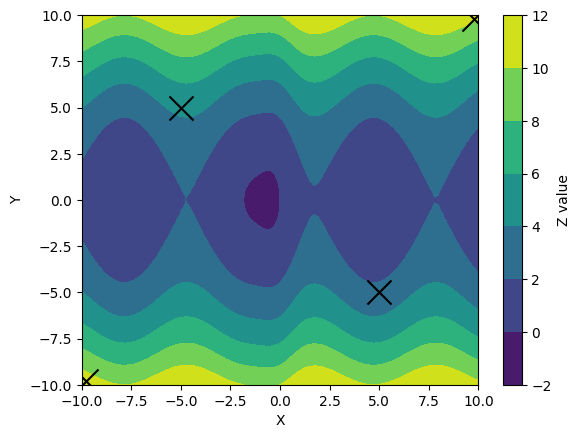

In [4]:
def my_system(X):
    return np.sin(X[:, 0]) - np.exp(-X[:, 0]**2) + X[:, 1]**2/10 + 1

# design the meshgrid data for plotting the contourmap
x, y = np.linspace(-10, 10, 100), np.linspace(-10, 10, 100)
X_mesh, Y_mesh = np.meshgrid(x, y)
X_candidates = np.column_stack([X_mesh.flatten(), Y_mesh.flatten()]) # also prepared the candidates set
Z_mesh = my_system(X_candidates).reshape(X_mesh.shape[0], X_mesh.shape[1])

# plot the 2D contourmap
fig = plt.figure()
ax = fig.add_subplot(111)

contour = ax.contourf(X_mesh, Y_mesh, Z_mesh, cmap='viridis')
fig.colorbar(contour, ax=ax, label='Z value')
ax.set_xlabel('X')
ax.set_ylabel('Y')

# also prepare our initial experiments
X = np.array([[-9.8, -9.8],
               [9.8, 9.8],
               [-5, 5],
               [5, -5]])
               
y = my_system(X)

ax.scatter(X[:,0],X[:,1], c='k', s=300, marker='x')

## fit a GP and see what the model thinks

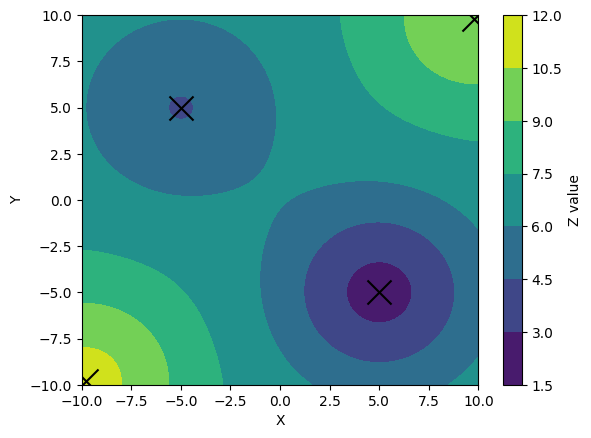

In [5]:
# fit the model
kernel = RationalQuadratic() + WhiteKernel(0.1)

gp = GaussianProcessRegressor(
    kernel=kernel,
    normalize_y=True,
    n_restarts_optimizer=100,
    random_state=0)

gp.fit(X, y)

Z = gp.predict(X_candidates).reshape(X_mesh.shape[0], X_mesh.shape[1])

# plot the 2D contourmap
fig = plt.figure()
ax = fig.add_subplot(111)

contour = ax.contourf(X_mesh, Y_mesh, Z, cmap='viridis')
fig.colorbar(contour, ax=ax, label='Z value')
ax.set_xlabel('X')
ax.set_ylabel('Y')

ax.scatter(X[:,0],X[:,1], c='k', s=300, marker='x')

## add experiments using Bayes Opt

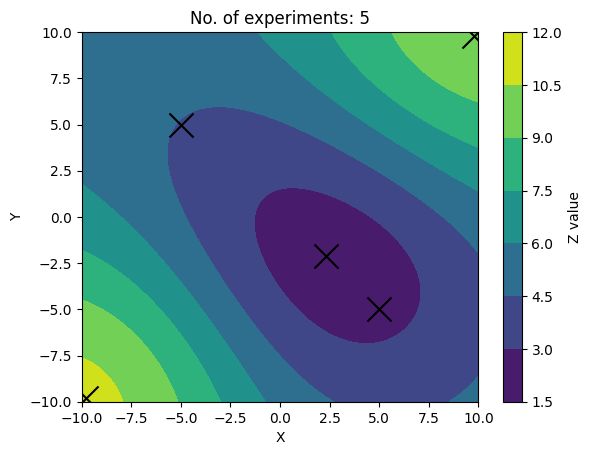

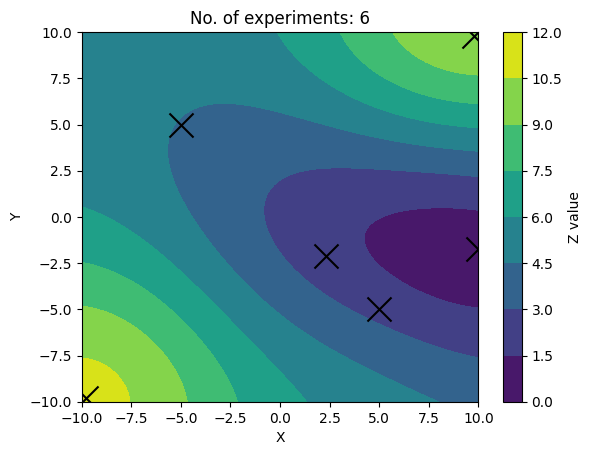

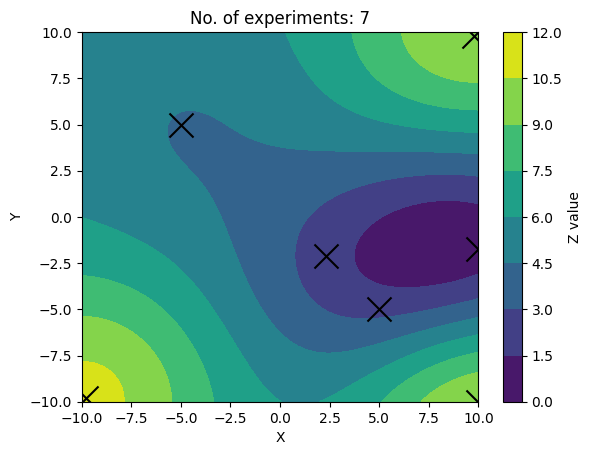

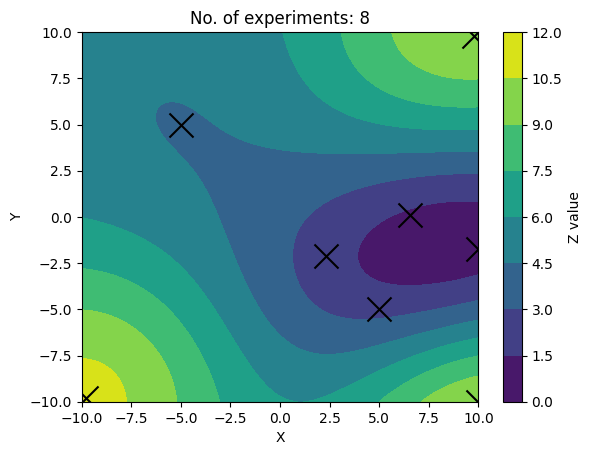

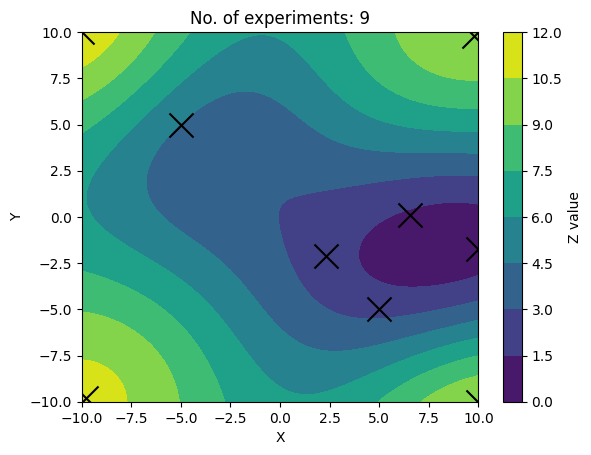

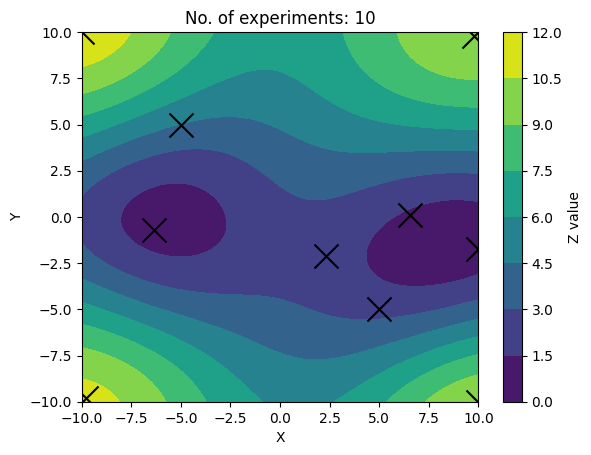

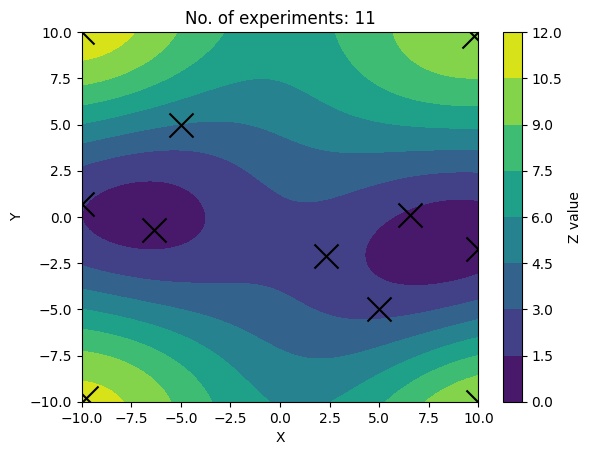

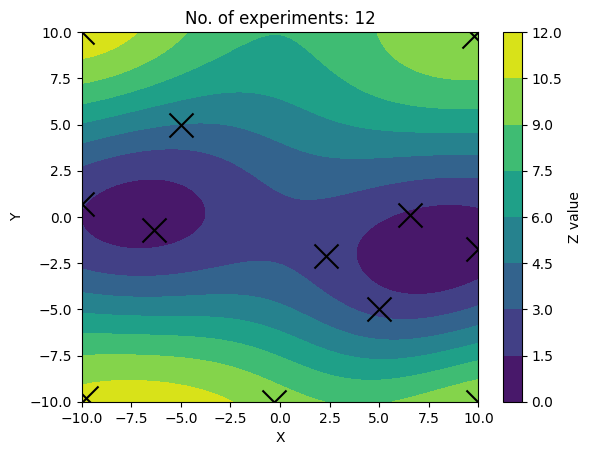

In [6]:
for _ in range(8):
    acq, i_suggested, X_suggested = suggest_next_experiment(X,
                                                            y,
                                                            X_candidates,
                                                            goal='min',
                                                            model_actual=gp,
                                                            acq_func_name='EI',
                                                            n_suggestions=1,
                                                            kriging_believer='prediction',
                                                            xi=2)

    X = np.vstack([X, X_suggested])
    y = my_system(X)

    # fit the model
    gp.fit(X, y)

    Z = gp.predict(X_candidates).reshape(X_mesh.shape[0], X_mesh.shape[1])

    # plot the 2D contourmap
    fig = plt.figure()
    ax = fig.add_subplot(111)

    contour = ax.contourf(X_mesh, Y_mesh, Z, cmap='viridis')
    fig.colorbar(contour, ax=ax, label='Z value')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(f'No. of experiments: {X.shape[0]}')

    ax.scatter(X[:,0],X[:,1], c='k', s=300, marker='x')

## let's compare this to some randomly chosen spots

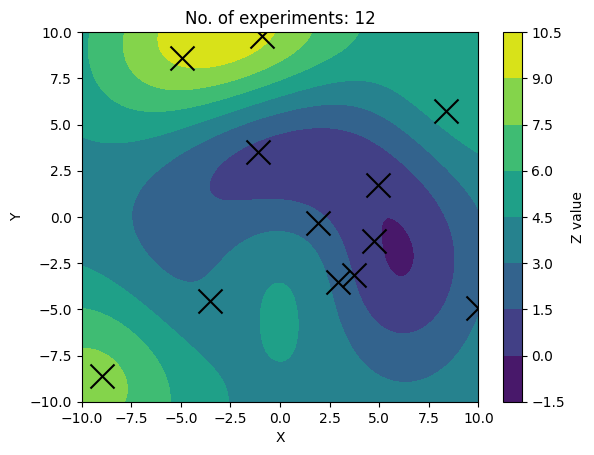

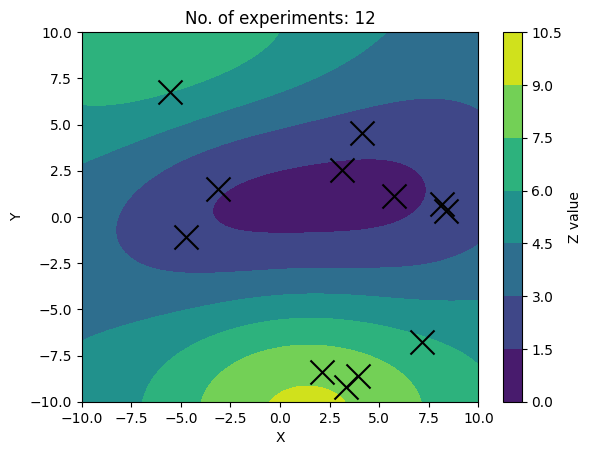

In [7]:
np.random.seed(0)
i = np.random.choice(X_candidates.shape[0], X.shape[0])

X_random = X_candidates[i]
y_random = my_system(X_random)

# fit the model
gp.fit(X_random, y_random)

Z_random = gp.predict(X_candidates).reshape(X_mesh.shape[0], X_mesh.shape[1])

# plot the 2D contourmap
fig = plt.figure()
ax = fig.add_subplot(111)

contour = ax.contourf(X_mesh, Y_mesh, Z_random, cmap='viridis')
fig.colorbar(contour, ax=ax, label='Z value')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title(f'No. of experiments: {X_random.shape[0]}')

ax.scatter(X_random[:,0],X_random[:,1], c='k', s=300, marker='x')

np.random.seed(42)
i = np.random.choice(X_candidates.shape[0], X.shape[0])

X_random = X_candidates[i]
y_random = my_system(X_random)

# fit the model
gp.fit(X_random, y_random)

Z_random = gp.predict(X_candidates).reshape(X_mesh.shape[0], X_mesh.shape[1])

# plot the 2D contourmap
fig = plt.figure()
ax = fig.add_subplot(111)

contour = ax.contourf(X_mesh, Y_mesh, Z_random, cmap='viridis')
fig.colorbar(contour, ax=ax, label='Z value')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title(f'No. of experiments: {X_random.shape[0]}')

ax.scatter(X_random[:,0],X_random[:,1], c='k', s=300, marker='x')

## what if we randomly sequentially sample

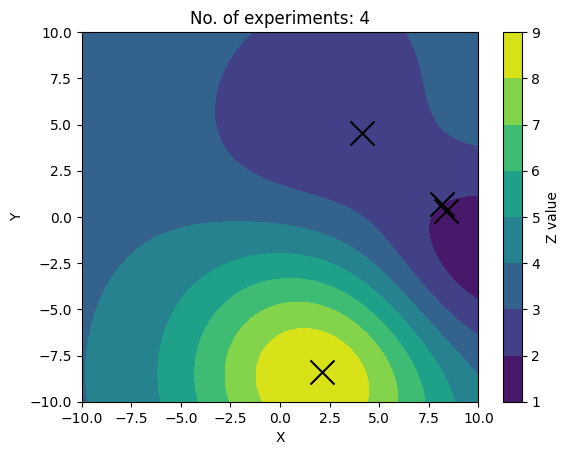

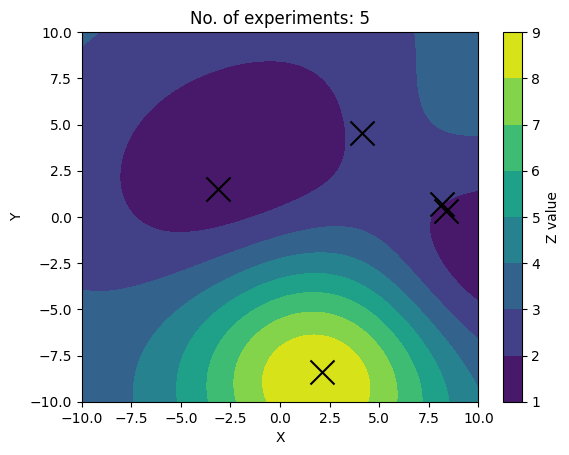

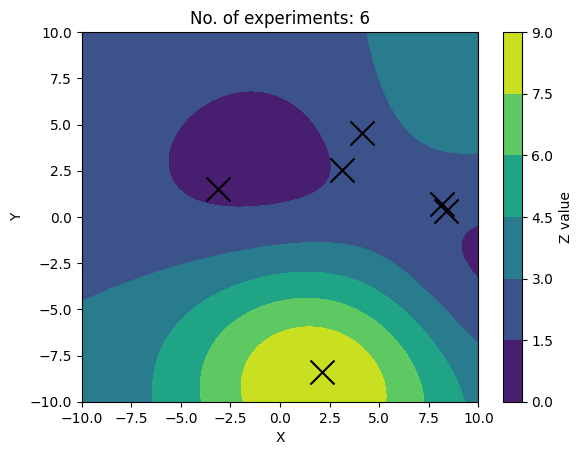

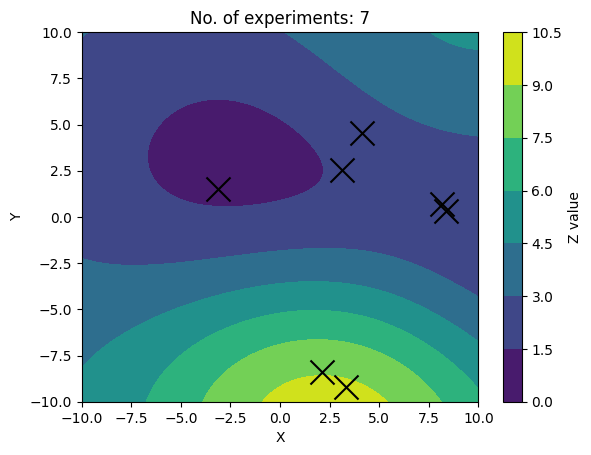

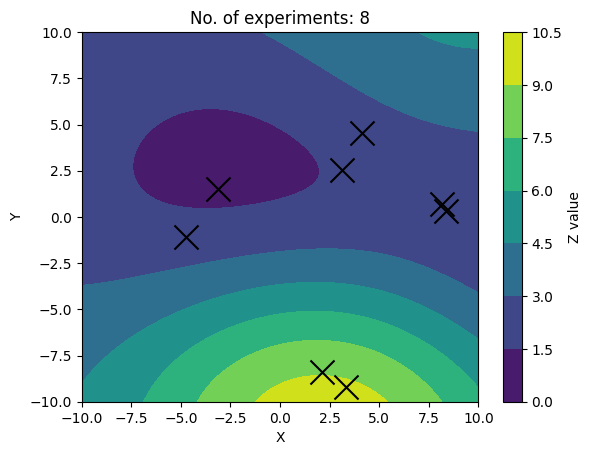

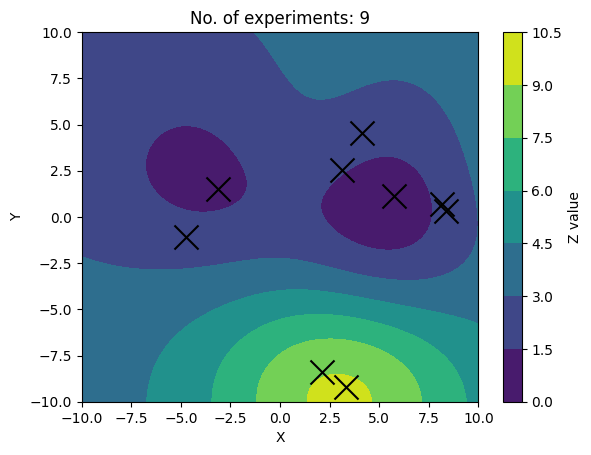

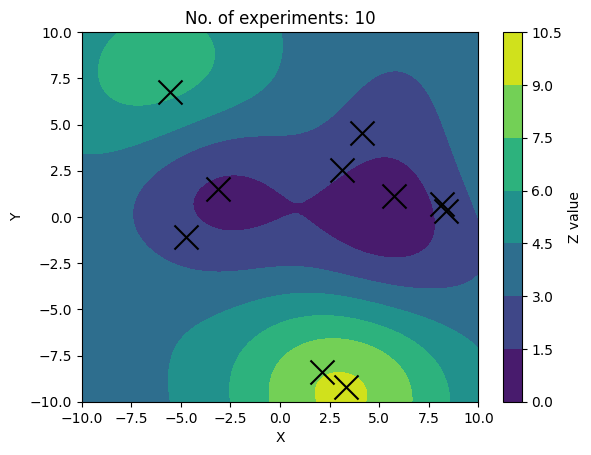

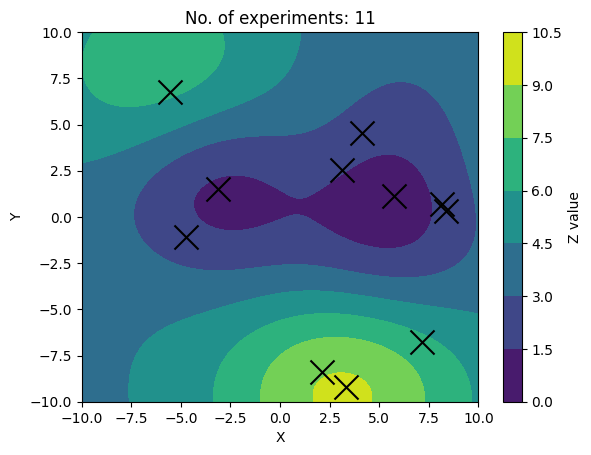

In [8]:
np.random.seed(42)
i = np.random.choice(X_candidates.shape[0], 4)

X_random = X_candidates[i]
y_random = my_system(X_random)

for _ in range(X.shape[0]-4):

    # fit the model
    gp.fit(X_random, y_random)

    Z_random = gp.predict(X_candidates).reshape(X_mesh.shape[0], X_mesh.shape[1])

    # plot the 2D contourmap
    fig = plt.figure()
    ax = fig.add_subplot(111)

    contour = ax.contourf(X_mesh, Y_mesh, Z_random, cmap='viridis')
    fig.colorbar(contour, ax=ax, label='Z value')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(f'No. of experiments: {X_random.shape[0]}')

    ax.scatter(X_random[:,0],X_random[:,1], c='k', s=300, marker='x')

    i = np.random.choice(X_candidates.shape[0], 1)
    X_random = np.vstack([X_random, X_candidates[i]])
    y_random = my_system(X_random)

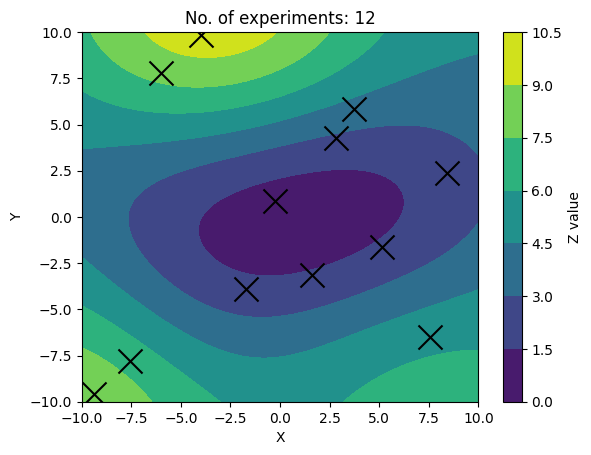

In [9]:
import numpy as np

def lhs(n, samples, low=-10, high=10):
    """Generate a Latin Hypercube Sample in n dimensions."""
    result = np.empty((samples, n))
    for i in range(n):
        perm = np.random.permutation(samples)
        result[:, i] = (perm + np.random.rand(samples)) / samples
    return low + (high - low) * result

# Example usage
X_lhs = lhs(n=2, samples=X.shape[0])
y_lhs = my_system(X_lhs)

# fit the model
gp.fit(X_lhs, y_lhs)

Z_lhs = gp.predict(X_candidates).reshape(X_mesh.shape[0], X_mesh.shape[1])

# plot the 2D contourmap
fig = plt.figure()
ax = fig.add_subplot(111)

contour = ax.contourf(X_mesh, Y_mesh, Z_lhs, cmap='viridis')
fig.colorbar(contour, ax=ax, label='Z value')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title(f'No. of experiments: {X_lhs.shape[0]}')

ax.scatter(X_lhs[:,0],X_lhs[:,1], c='k', s=300, marker='x')